# COMP5318 Assignment 2
*Make sure you change the file name with your unikey*


# 1. Data set up


## 1.1 Load Data

*Please upload both datasets (any file format is ok) to your google drive, and load the datasets through google drive file id in your code. If you want to use Jupyter, please submit all the dataset in an additional zip file.*



In [0]:
import os
import pickle # store the learning model
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; # assist matplotlib (heatmap)
import numpy as np
from numpy import asarray


#Downloading files
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# download trip-advisor
id = '1CeL8s1aXEPRvijTKLnROYNMQwfgNGMUm'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('trip_advisor.csv')

# download paper
id = '1rY1c-gew4mhBZcqYVjcxsXIK57Lv9Ld4'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('paper.csv')

import pandas as pd
trip_advisor = pd.read_csv('trip_advisor.csv')
# print(trip_advisor)
paper = pd.read_csv('paper.csv')
# print(paper)

## 1.2 Data Preprocessing (optional)

***You are required to show your data preprocessing methods for the two datasets (if necessary)***

*You can apply different data preprocessing techniques in different data and clustering models if you need.*


### Travel Review Dataset

In [0]:
# delete User ID 
userID = trip_advisor['User ID']
trip_advisor = trip_advisor.drop(['User ID'],axis=1)

# change from pandas to np matrix
trip_advisor=np.array(trip_advisor)
# change the type of matrix elements from str to int
[rows, cols] = trip_advisor.shape
for i in range(rows):
    for j in range(cols):
        trip_advisor[i][j] = float(trip_advisor[i][j])
# print(trip_advisor.shape)

### ICMLA Datasets

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<class 'numpy.ndarray'>


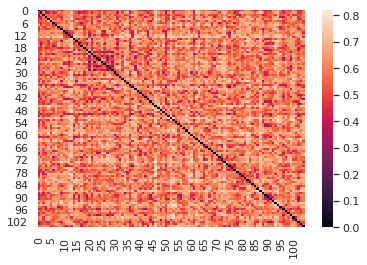

In [13]:
# seperate paper data
keywords = paper['author_keywords']
abstract = paper['abstract']
title = paper['paper_title']
gold_cluster = paper['session']

# store to pickle file first
abstract_pickle = open('abstract.pkl', 'wb')
pickle.dump(abstract, abstract_pickle)
abstract_pickle.close()

# open pickle file
abstract_pkl = pickle.load(open('abstract.pkl', 'rb'))

 # define tokenization function
import nltk
from nltk.stem.snowball import SnowballStemmer
import re

stemmer = SnowballStemmer("english")
nltk.download('punkt')
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# construct numerical representation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns; 

# TfidfVectorizer will perform the vectorisation. Please explore the parameters at the user guide
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
# apply abstract to TFIDF
abstract_matrix = tfidf_vectorizer.fit_transform(abstract_pkl)

# calculate cosine difference (1-similarity) of abstract
dist_abs = 1 - cosine_similarity(abstract_matrix)
print(type(dist_abs))

# calculate jaccard difference on title and keywords
!pip install Distance
import distance
title_list = []
for i in range(len(title)):
  temp = []
  for j in range(len(title)):
    temp.append(distance.jaccard(title[i], title[j]))
  title_list.append(temp)
title_matrix = np.matrix(title_list)
# print(title_matrix.shape)

keywords_list = []
for i in range(len(keywords)):
  temp = []
  for j in range(len(keywords)):
    temp.append(distance.jaccard(keywords[i], keywords[j]))
  keywords_list.append(temp)
keywords_matrix = np.matrix(keywords_list)
# print(keywords_matrix.shape)

# total paper disimilarity = Θ1∗DM(abs)+Θ2∗DM(keywords)+Θ3∗DM(title)
paper_matrix = 0.55*dist_abs + 0.35*keywords_matrix + 0.1*title_matrix

# draw heat map of paper preprocessed data
sns.set()
ax = sns.heatmap(paper_matrix)



---


# 2. K-means Clustering

## 2.1 Travel Review Dataset

### Train K-means clustering

In [0]:
# kmeans using euclidean similarity
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(trip_advisor)
                for k in range(1, 11)]

# self-define k-means function using cosine distance
from sklearn.metrics import pairwise_distances_argmin
def find_clusters(X, n_clusters, rseed=2, label=False):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        # metric can be  'cosine', 'euclidean', 'manhattan'
        labels = pairwise_distances_argmin(X, centers, metric='cosine')
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    if label:
      return labels
    else:
      return centers

# build another model using cosine
centers = [find_clusters(trip_advisor, i)
          for i in range(1, 11)]


### First evaluation 

euclidean, k = 6 835.9948440481027
euclidean, k = 7 795.7060543492548
euclidean, k = 8 752.7777107278805


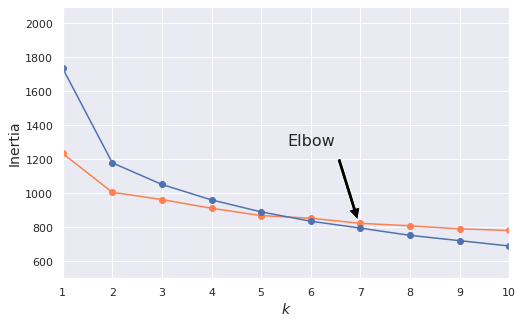

In [15]:
# rewrite Elbow for cosine evaluation
from scipy.spatial.distance import cdist
iner_cos = [sum(np.min(cdist(trip_advisor, model, 'euclidean'),axis=1))
            for model in centers]

# Elbow method
inertias = [model.inertia_ for model in kmeans_per_k]

# find elbow point
elbow_diff = 10000
elbow_k = 0
for i in range(len(inertias)-1):
  temp = inertias[i] - inertias[i+1]
  if temp < elbow_diff:
    elbow_diff = temp
  else:
    elbow_k = i+1
    break
# print('elbow k should be {}'.format(elbow_k))

# print inertia k=6 to k=8
for i in range(6,9):
  print('euclidean, k =',i,inertias[i-1])

# plot inertia of diff k
plt.figure(figsize=(8, 5))
plt.plot(range(1,11), iner_cos, "bo-", color='coral')
plt.plot(range(1, 11), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(7, inertias[6]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 500, 2100])
plt.show()

### Second evaluation 

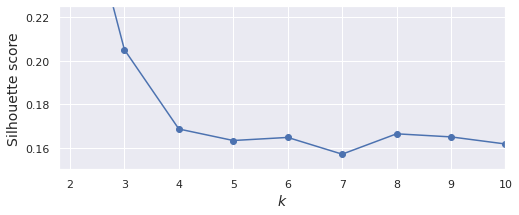

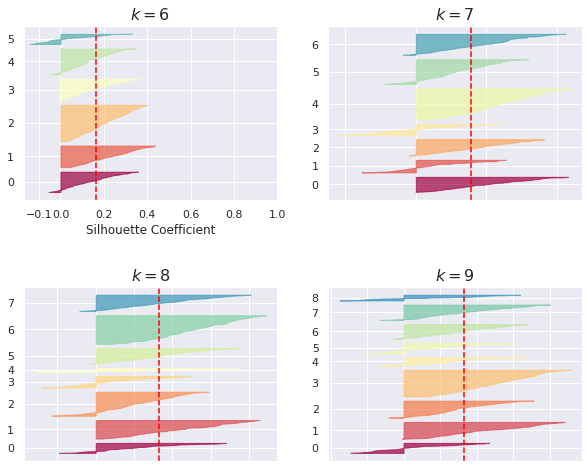

In [16]:
# Silhouette score
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(trip_advisor, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 10, 0.150, 0.225])
plt.show()

# here Silhouette score suggests k = 8 or k = 6
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(10, 8))

for k in (6, 7, 8, 9):
    plt.subplot(2, 2, k - 5)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(trip_advisor, y_pred)

    padding = len(trip_advisor) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (3, 4, 5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

## 2.2 ICMLA Dataset

### Train K-means clustering

In [0]:
# here only take abstract content into account
# similarity distance using euclidean
icmla_kmeans_per_k = [KMeans(n_clusters=i, random_state=42).fit(abstract_matrix)
                      for i in range(10,26)]
icmla_kmeans_pre = [ model.predict(abstract_matrix)
                      for model in icmla_kmeans_per_k]
# similarity distance using cosine
labels20 = [ find_clusters(abstract_matrix.toarray(), i, label = True)
            for i in range(10,26)]

### First evaluation

In [0]:
# this section design the gold cluster
# form the gold cluster in max_list function
glod_cluster_num =[]

# purity evaluation
def max_list(lt):
    temp = 0
    max_ele = 0
    for i in lt:
      if lt.count(i) > temp:
        max_ele = i
        temp = lt.count(i)
    for j in range (len(lt)):
      glod_cluster_num.append(max_ele)
    return temp

def get_purity(y_pre):
  # refresh the cache
  # print('previous gold cluster', glod_cluster_num)
  glod_cluster_num.clear()
  # manually cut results into 20 parts
  part_1 = y_pre[0:5].tolist()
  part_2 = y_pre[5:10].tolist()
  part_3 = y_pre[10:15].tolist()
  part_4 = y_pre[15:20].tolist()
  part_5 = y_pre[20:30].tolist()
  part_6 = y_pre[30:35].tolist()
  part_7 = y_pre[35:40].tolist()
  part_8 = y_pre[40:45].tolist()
  part_9 = y_pre[45:52].tolist()
  part_10 = y_pre[52:56].tolist()
  part_11 = y_pre[56:60].tolist()
  part_12 = y_pre[60:65].tolist()
  part_13 = y_pre[65:73].tolist()
  part_14 = y_pre[73:81].tolist()
  part_15 = y_pre[81:85].tolist()
  part_16 = y_pre[85:89].tolist()
  part_17 = y_pre[89:94].tolist()
  part_18 = y_pre[94:97].tolist()
  part_19 = y_pre[97:102].tolist()
  part_20 = y_pre[102:105].tolist()
  
  return (max_list(part_1)+max_list(part_2)+max_list(part_3)+max_list(part_4)+max_list(part_5)+max_list(part_6)+max_list(part_7)
  +max_list(part_8)+max_list(part_9)+max_list(part_10)+max_list(part_11)+max_list(part_12)+max_list(part_13)+max_list(part_14)+
  +max_list(part_15)+max_list(part_16)+max_list(part_17)+max_list(part_18)+max_list(part_19)+max_list(part_20)) / len(y_pre)

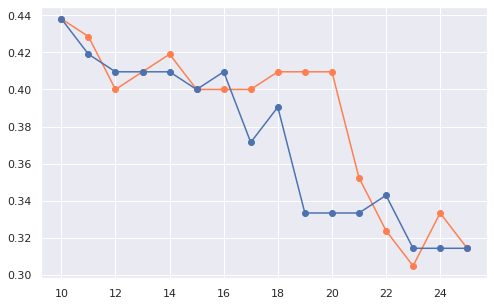

In [19]:
# get purity result
euc_purity = [get_purity(i)
              for i in icmla_kmeans_pre]
cos_purity = [get_purity(i)
              for i in labels20]
plt.figure(figsize=(8, 5))
plt.plot(range(10,26), euc_purity, "bo-", color='coral')
plt.plot(range(10, 26), cos_purity, "bo-")
plt.show()

### Second evaluation 

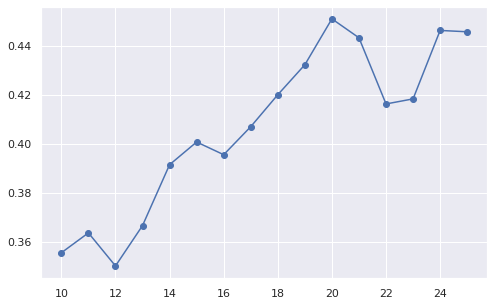

In [20]:
import math
# define NMI method
def NMI(A,B):
    total = len(A)
    A_ids = set(A)
    B_ids = set(B)
    # calculate entropy
    MI = 0
    eps = 1.4e-45
    for idA in A_ids:
        for idB in B_ids:
            idAOccur = np.where(A==idA)
            idBOccur = np.where(B==idB)
            idABOccur = np.intersect1d(idAOccur,idBOccur)
            px = 1.0*len(idAOccur[0])/total
            py = 1.0*len(idBOccur[0])/total
            pxy = 1.0*len(idABOccur)/total
            MI = MI + pxy*math.log(pxy/(px*py)+eps,2)
    # normalization
    Hx = 0
    for idA in A_ids:
        idAOccurCount = 1.0*len(np.where(A==idA)[0])
        Hx = Hx - (idAOccurCount/total)*math.log(idAOccurCount/total+eps,2)
    Hy = 0
    for idB in B_ids:
        idBOccurCount = 1.0*len(np.where(B==idB)[0])
        Hy = Hy - (idBOccurCount/total)*math.log(idBOccurCount/total+eps,2)
    MIhat = 2.0*MI/(Hx+Hy)
    return MIhat

NMI_results = [NMI(i, np.array(glod_cluster_num))
                for i in icmla_kmeans_pre]
plt.figure(figsize=(8, 5))
plt.plot(range(10,26), NMI_results, "bo-")
plt.show()



---


# 3. Hierachical Clustering

## 3.1 Travel Review Dataset

### Train Hierarchical clustering 

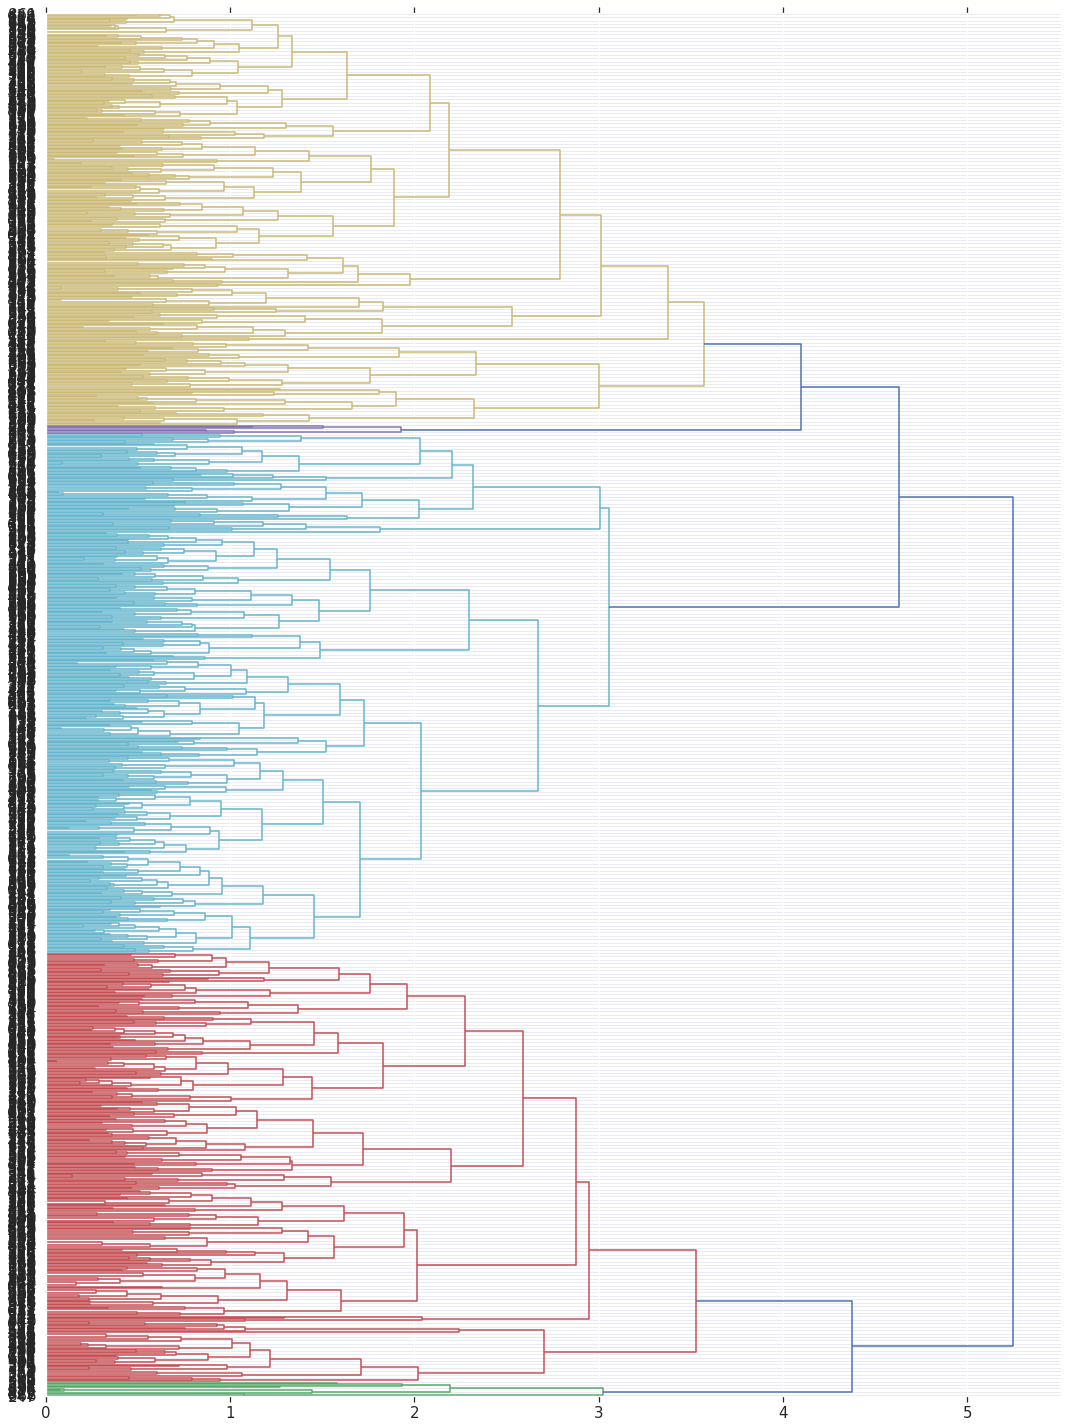

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# constract different linkage matrix with differetn method and metric
# differnt method when metric = euclidean 
trip_hi_avg_euclidean = linkage(trip_advisor, method='average', metric='euclidean')
trip_hi_sig_euclidean = linkage(trip_advisor, method='single', metric='euclidean')
trip_hi_cmp_euclidean = linkage(trip_advisor, method='complete', metric='euclidean')
# different method when metric = cosine
trip_hi_avg_cosine = linkage(trip_advisor, method='average', metric='cosine')
trip_hi_sig_cosine = linkage(trip_advisor, method='single', metric='cosine')
trip_hi_cmp_cosine = linkage(trip_advisor, method='complete', metric='cosine')

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(trip_hi_cmp_euclidean, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',
    labelsize=15
    )
plt.tick_params(\
    axis= 'y',          # changes apply to the y-axis
    labelsize=15
    )

plt.tight_layout() #show plot with tight layout

### First evaluation 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz

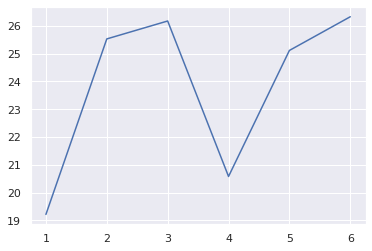

In [22]:
# calinski_harabaz_score
from sklearn import metrics
from sklearn.metrics import calinski_harabaz_score
# 1. metric='euclidean' method='single'
ft_sig_eu = fcluster(trip_hi_sig_euclidean, t = 0.9)
# 1. metric='euclidean' method='complete'
ft_cmp_eu = fcluster(trip_hi_cmp_euclidean, t = 0.9) 
# 1. metric='euclidean' method='average'
ft_avg_eu = fcluster(trip_hi_avg_euclidean, t = 0.9) 
# 1. metric='cosine' method='single'
ft_sig_cos = fcluster(trip_hi_sig_cosine, t = 0.9) 
# 1. metric='cosine' method='complete'
ft_cmp_cos = fcluster(trip_hi_cmp_cosine, t = 0.9) 
# 1. metric='cosine' method='average'
ft_avg_cos = fcluster(trip_hi_avg_cosine, t = 0.9)

z1 = calinski_harabaz_score(trip_advisor,ft_sig_eu)
z2 = calinski_harabaz_score(trip_advisor,ft_cmp_eu)
z3 = calinski_harabaz_score(trip_advisor,ft_avg_eu)
z4 = calinski_harabaz_score(trip_advisor,ft_sig_cos)
z5 = calinski_harabaz_score(trip_advisor,ft_cmp_cos)
z6 = calinski_harabaz_score(trip_advisor,ft_avg_cos)

CH_plot = [z1, z2, z3,z4, z5, z6]

plt.plot(range(1, 7), CH_plot)

### Second evaluation 

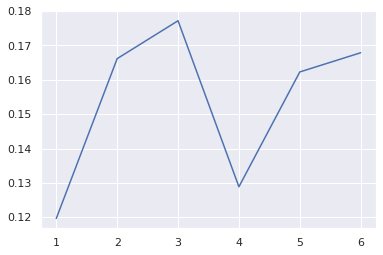

In [23]:
# Silhouette score
from sklearn.metrics import silhouette_score
w1 = silhouette_score(trip_advisor, ft_sig_eu)
w2 = silhouette_score(trip_advisor, ft_cmp_eu)
w3 = silhouette_score(trip_advisor, ft_avg_eu)
w4 = silhouette_score(trip_advisor, ft_sig_cos)
w5 = silhouette_score(trip_advisor, ft_cmp_cos)
w6 = silhouette_score(trip_advisor, ft_avg_cos)

sil_plot = [w1, w2, w3, w4, w5, w6]
plt.plot(range(1, 7), sil_plot)

## 3.2 ICMLA Dataset

### Train Hierarchical clustering 

In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# constract different linkage matrix with differetn method and metric
# differnt method when metric = euclidean 
icmla_hi_avg_euclidean = linkage(paper_matrix, method='average', metric='euclidean')
icmla_hi_sig_euclidean = linkage(paper_matrix, method='single', metric='euclidean')
icmla_hi_cmp_euclidean = linkage(paper_matrix, method='complete', metric='euclidean')
# different method when metric = cosine
icmla_hi_avg_cosine = linkage(paper_matrix, method='average', metric='cosine')
icmla_hi_sig_cosine = linkage(paper_matrix, method='single', metric='cosine')
icmla_hi_cmp_cosine = linkage(paper_matrix, method='complete', metric='cosine')




### First evaluation

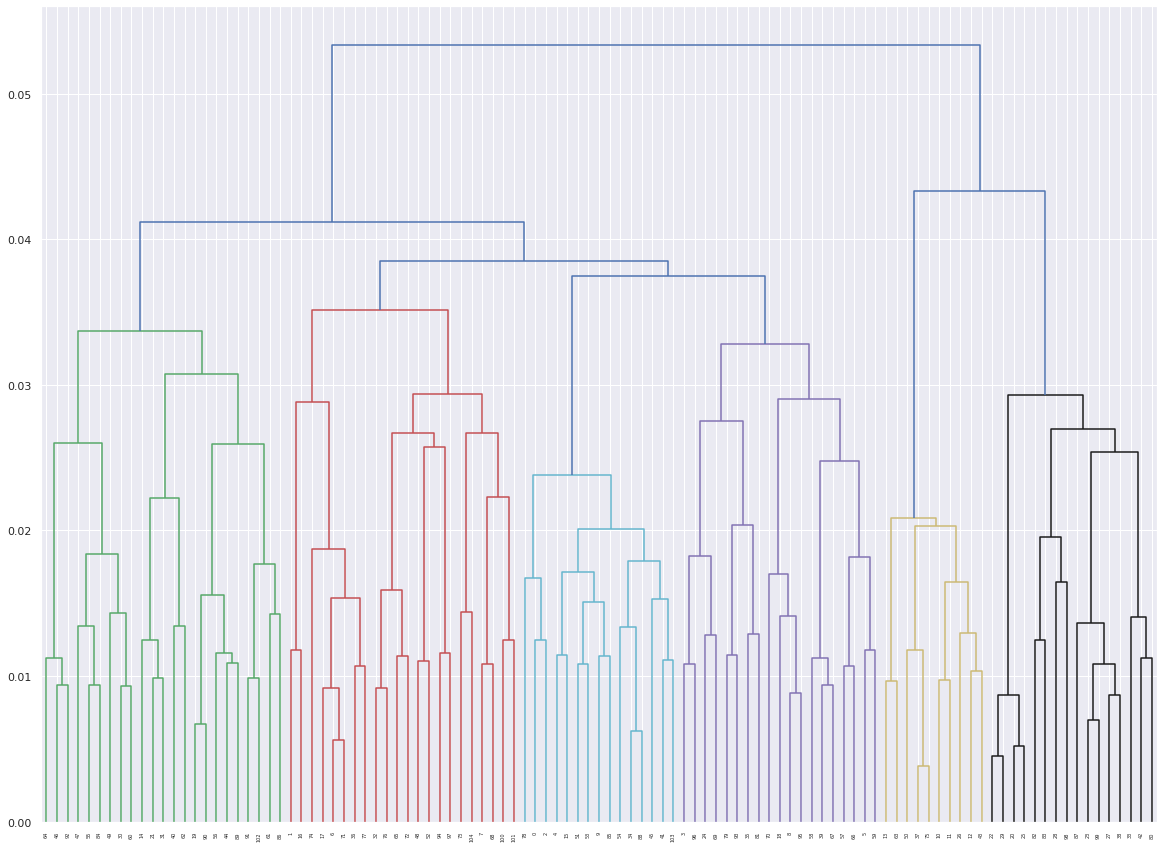

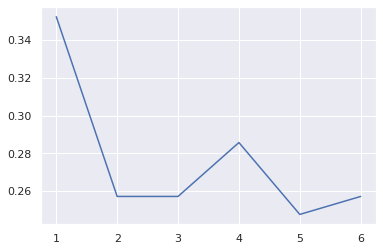

In [25]:
# get different cluster result
# 1. metric='euclidean' method='single'
f_sig_eu = fcluster(icmla_hi_sig_euclidean, t = 0.9)
# 1. metric='euclidean' method='complete'
f_cmp_eu = fcluster(icmla_hi_cmp_euclidean, t = 0.9) 
# 1. metric='euclidean' method='average'
f_avg_eu = fcluster(icmla_hi_cmp_euclidean, t = 0.9) 
# 1. metric='cosine' method='single'
f_sig_cos = fcluster(icmla_hi_sig_cosine, t = 0.9) 
# 1. metric='cosine' method='complete'
f_cmp_cos = fcluster(icmla_hi_cmp_cosine, t = 0.9) 
# 1. metric='cosine' method='average'
f_avg_cos = fcluster(icmla_hi_avg_cosine, t = 0.9) 

x1 = get_purity(f_sig_eu)
y1_pre = glod_cluster_num
x2 = get_purity(f_cmp_eu)
y2_pre = glod_cluster_num
x3 = get_purity(f_avg_eu)
y3_pre = glod_cluster_num
x4 = get_purity(f_sig_cos)
y4_pre = glod_cluster_num
x5 = get_purity(f_cmp_cos)
y5_pre = glod_cluster_num
x6 = get_purity(f_avg_cos)
y6_pre = glod_cluster_num

purity_plot = [x1, x2, x3,x4, x5, x6]

fig = plt.figure(figsize=(20, 15))
dn = dendrogram(icmla_hi_cmp_cosine)
plt.show()

plt.plot(range(1, 7), purity_plot)


### Second evalaution 

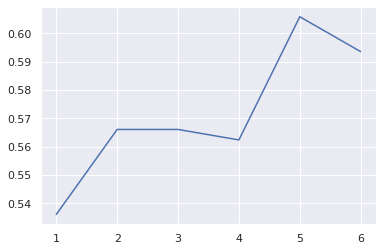

In [26]:
# NMI evaluation
NMI_plot = [NMI(f_sig_eu,np.array(y1_pre)),NMI(f_cmp_eu,np.array(y2_pre)),NMI(f_avg_eu,np.array(y3_pre)),
            NMI(f_sig_cos,np.array(y4_pre)),NMI(f_cmp_cos,np.array(y5_pre)),NMI(f_avg_cos,np.array(y6_pre))]
plt.plot(range(1, 7), NMI_plot)



---


# 4. DBSCAN Clustering

## 4.1 Travel Review Dataset

### Train DBSCAN clustering 

In [0]:
from sklearn.cluster import DBSCAN
dbscan_result = [DBSCAN(eps=float(m/100), min_samples=n).fit_predict(trip_advisor)
                for m in range(60,75)
                  for n in range(5,20)]



### First evaluation

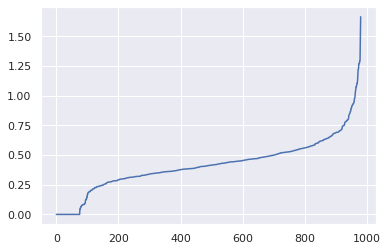

In [28]:
# find the best eps range 0.6<eps<0.75
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(trip_advisor)
distances, indices = nbrs.kneighbors(trip_advisor)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

plt.show()


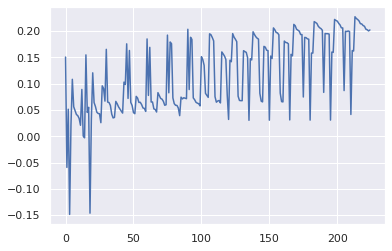

In [29]:
# determine best min_sample
from sklearn.metrics import silhouette_score
silhou_score = []

for i in range(len(dbscan_result)):
  if np.mean(dbscan_result[i]) > -1:
    silhou_score.append(silhouette_score(trip_advisor, dbscan_result[i]))
  else:
    silhou_score.append(0)

plt.plot(range(len(dbscan_result)), silhou_score)


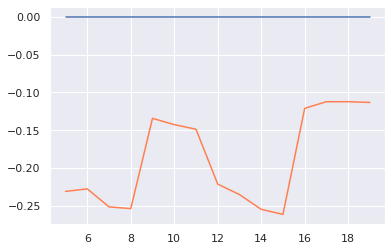

In [30]:
# add cosine metric to determine the similarity method
db_eul = [DBSCAN(eps=0.45, min_samples=n,metric='euclidean').fit_predict(trip_advisor)
                          for n in range(5,20)]
db_cos = [DBSCAN(eps=0.7, min_samples=n,metric='cosine').fit_predict(trip_advisor)
                          for n in range(5,20)]
z1 = []
z2 = []
for i in range(len(db_eul)):
  if np.mean(db_eul[i]) > -1:
    z1.append(silhouette_score(trip_advisor, db_eul[i]))
  else:
    z1.append(0)
for i in range(len(db_cos)):
  if np.mean(db_cos[i]) > 0:
    z2.append(silhouette_score(trip_advisor, db_cos[i]))
  else:
    z2.append(0)

plt.plot(range(5,20), z1,color='coral')
plt.plot(range(5,20), z2)

### Second evaluation 

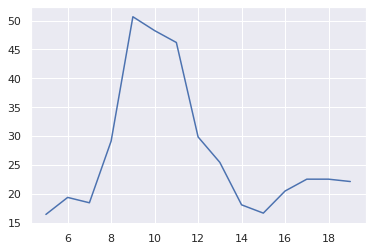

In [31]:
from sklearn.metrics import calinski_harabasz_score
calinski_score = []
for i in range(len(db_eul)):
  if np.mean(db_eul[i]) > -1:
    calinski_score.append(calinski_harabasz_score(trip_advisor,db_eul[i]))
  else:
    calinski_score.append(-1)

plt.plot(range(5,5+len(db_eul)), calinski_score)

## 4.2 ICMLA Dataset

### Train DBSCAN clustering 

In [61]:
from sklearn.cluster import DBSCAN
icmla_dbscan_result = [DBSCAN(eps=0.9, min_samples=n).fit_predict(abstract_matrix)
                for n in range(5,20)]
print(len(icmla_dbscan_result))

icmla_dbscan_result_cos = [DBSCAN(eps=0.9, min_samples=n, metric='cosine').fit_predict(abstract_matrix)
                for n in range(5,20)]

15
15


### First evaluation 

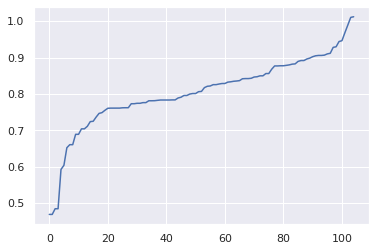

In [33]:
# find the best eps range
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(abstract_matrix)
distances, indices = nbrs.kneighbors(abstract_matrix)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

plt.show()

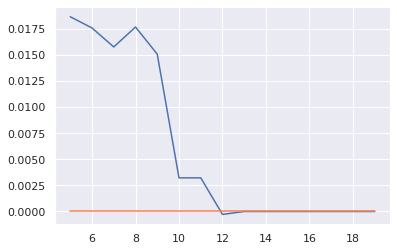

In [63]:
from sklearn.metrics import adjusted_rand_score
ars_score = [ adjusted_rand_score(model, gold_cluster)
                    for model in icmla_dbscan_result]
ars_score_cos = [ adjusted_rand_score(model, gold_cluster)
                    for model in icmla_dbscan_result_cos]            
plt.plot(range(5, 20), ars_score)
plt.plot(range(5, 20), ars_score_cos,color='coral')  

### Second evaluation 

eps: 0.900000, min_samples: 3
0.4397439385506004
eps: 0.900000, min_samples: 4
0.4039111026727459
eps: 0.900000, min_samples: 5
0.4391725194245024
eps: 0.900000, min_samples: 6
0.3932231578081371
eps: 0.900000, min_samples: 7
0.38587281101985743
eps: 0.900000, min_samples: 8
0.45510957408764086
eps: 0.900000, min_samples: 9
0.4573636879899747
eps: 0.900000, min_samples: 10
0.4050666938596466
eps: 0.900000, min_samples: 11
0.4050666938596466
eps: 0.900000, min_samples: 12
0.36382879353491
eps: 0.900000, min_samples: 13
1.0
eps: 0.900000, min_samples: 14
1.0
eps: 0.900000, min_samples: 15
1.0
eps: 0.950000, min_samples: 3
0.4779839984054268
eps: 0.950000, min_samples: 4
0.42575463163638305
eps: 0.950000, min_samples: 5
0.46467387078854977
eps: 0.950000, min_samples: 6
0.3961296004988771
eps: 0.950000, min_samples: 7
0.3518874672585375
eps: 0.950000, min_samples: 8
0.33696032696355216
eps: 0.950000, min_samples: 9
0.33510424648020565
eps: 0.950000, min_samples: 10
0.3770886320745811
eps: 

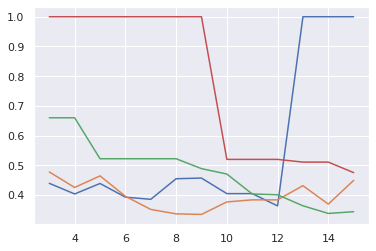

In [60]:
# evaluation using homogeneity score
from sklearn.metrics import homogeneity_score
homo_score = []
for e in [0.90, 0.95, 1.00, 1.05]:
  temp = []
  for s in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
      dbscan = DBSCAN(eps=e, min_samples=s)
      dbscan.fit(abstract_matrix)
      score = metrics.homogeneity_score(dbscan.labels_, gold_cluster)
      print('eps: %f, min_samples: %d' % (e, s))
      print(score)
      temp.append(score)
  homo_score.append(temp)

for i in range(len(homo_score)):
  plt.plot(range(3, 16), homo_score[i],label = i)